# Direct Marketing Optimization using Mobile Data

*A classification approach to strategize projected growths in user subscription*

*Authors*: Ketul Patel, Harsh Nisar


## Motivation

A banking institution ran a direct marketing campaign based on phone calls. Oftentimes, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be subscribed or not. To solve this, we will predict whether someone will subscribe to the term deposit or not based on the given information.


## Dataset

We use data.csv which contains the following fields:

1. age (numeric)
2. job: type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
3. marital_status: marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
5. credit_default: has credit in default? (categorical: "no","yes","unknown")
6. housing: has housing loan? (categorical: "no","yes","unknown")
7. loan: has personal loan? (categorical: "no","yes","unknown")
8. contact: contact communication type (categorical: "cellular","telephone")
9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
11. duration: last contact duration, in seconds (numeric).
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. prev_days: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. prev_contacts: number of contacts performed before this campaign and for this client (numeric)
15. prev_outcomes: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
16. emp_var_rate: employment variation rate - quarterly indicator (numeric)
17. cons_price_idx: consumer price index - monthly indicator (numeric)
18. cons_conf_idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr_employed: number of employees - quarterly indicator (numeric)
21. **subscribed** (target variable): has the client subscribed a term deposit? (binary: "yes","no")

## Technique Overview

Our original approach was to create a simple poor man's stacking ensemble with models that were somewhat simplistic. We first tried stacking NaiveBayes, RandomForest, ExtraTreeClassifier, SVM and logistic regression together. These models performed well with regards to cross validation and on the testing set with roc-auc scores around 0.78-0.8. However, when submitting the Kaggle the score dropped to 0.76. Gaussian Naive Bayes was one of the strongest performers though did not add anything to the ensemble methods. As an aside, we tried NearestCentroid and KNN though had issues with consistent predict_proba calls so dropped these models as well.

*Note that all model hyperparameters were tuned using GridSearch with cv=5. Not all grid searches are included due to time in execution of the notebook.

Moving forward we decided to drop the SVM all together due to time constraints and drop NaiveBayes since it was performing strangely. We were then left with gradient boosting, ada boosting, easy ensembles, random forests and logistic regression with feature selection. The ExtraTree classifier was left out since the random forests would be more powerful and pick up on similar trends. AdaBoosting overfit too much and dominated the stacking ensemble. The gradient boost also overfit quite a lot but there seemed to be an improvement in the Kaggle scores when using this model. Cross-validation and the test set showed roc-auc's around 0.8 - 0.82 with the ensemble methods implementing the gradient boosted random forest. This left us with Gradient Boosting random forests and different implementations of logistic regression such as AdaBoost, easy ensemble and other sampling techniques.

The feature selection showed little imrpovements applied to all of the data prior to the voting classifier for poor-man's stacking. This was due to the tree models we were using. Instead, applying an RFE(RandomForest()) selector prior to logistic regression alone seemed to perform the best.

Standard scaling and min-max scaling seemed to perform similarly with standard scaling having a slight edge. This is contrary to our belief since the binary data from the dummy variables is between 0 and 1 where the standard scaler would shift the 0's to negative values.

Again, contrary to our belief, SMOTE and omitting a technique to deal with imbalance performed much better than using RandomUnderSampler. Using SMOTE(ratio = 0.5) followed by RandomUnderSampler seemed to give a compromise between the performance of SMOTE alone and RandomUnderSampler alone though showed no improvement over SMOTE alone. This was gauged with regard to logistic regression and the poor-man's stacking classifier.

Another approach we tried was to create an easy ensemble out of the voting classifiers which overfitted, though not as bad as adaboosting, and the results seemed to stay consistent regardless of the number of classifiers used. A further analysis of the affect of number of classifiers on easy ensemble is included at the very end in the analysis of resampling techniques.


## Technique Summary

### 0. Import Libraries and Load Data

    0.1. Load data and convert unknowns to nulls
    0.2. Categorize features based on types
    0.3. Define response variable
    0.4. Split data into training and test set

### 1. Exploration and Preparation

    1.1. Identify possible associations between dependent and independent variables
            * Includes a scatterplot matrix, density plots, and histograms.
    1.2. Convert yes/no values to 1/0
    1.3. Create dummies for categorical variables
    1.4. Create binary prev_days indicator
    1.5. Impute missing values
    1.6. Select significant variables
    1.7. Deal with imbalanced data
            * Includes oversampling and undersampling techniques.

### 2. Classification Models

    2.1. Logistic Regression
    2.2. Linear SVM
    2.3. Kernelized SVM (RBF)
    2.4. Naive Bayes
    2.5. Stochastic Gradient Descent Classifier
    2.6. Nearest Centroid Classifier
    2.7. Logistic Regression with Resampled Ensemble
    2.8. Logistic Regression with RFE
    2.9. Logistic Regression with RFE Lasso
    2.10. Model Evaluation (ROC-AUC & F-1 Scores)

### 3. Tree-based Models

    3.1. Decision Tree
    3.2. Random Forest
    3.3. Bagging
    3.4. Gradient Boosting
    3.5. Adaboost
    3.6. Extra Tree Classifier
    3.7. Model Evaluation (ROC-AUC & F-1 Scores)

### 4. Ensemble Models

    4.1. Poor Man's Stacking using Gradient Boosted Classifier and an Easy Ensemble of Logistic Regressions
    4.2. Poor Man's Stacking using Random Forest Classifier and Easy Ensemble of Logistic Regressions
    4.3. Model Evaluation

### 5. Resampling Techniques

    5.1. Sampling Transformation and Analysis
    5.2. Sampling Techniques Evaluation on Poor-man's Stacking Algorithm
    5.2. Easy Ensembles
    5.4. AdaBoost Resampled Ensembles

## Step 0 - Import Libraries and Load Data

This is the basic step where we load the data and create train and test sets for internal validation.


In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams["figure.dpi"] = 100
np.set_printoptions(precision=3, suppress=True)

### 0.1. Load data and convert unknowns to nulls

Unknown values in the dataset seem to be clean and consistent, encoded as unknown. In this case, we can convert them to null values while importing the data.


In [28]:
data = pd.read_csv('data.csv', delimiter = ',', na_values='unknown')
data.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,...,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed
0,41.0,blue-collar,married,basic.9y,no,yes,no,cellular,apr,mon,...,2.0,999,0,nonexistent,-1.695118,92.698705,-46.727552,1.345160,5097.0,no
1,46.0,entrepreneur,married,NaN,no,no,no,cellular,may,wed,...,2.0,999,0,nonexistent,-1.767159,92.914878,-46.313088,1.314499,5100.0,no
2,56.0,unemployed,married,basic.9y,no,yes,yes,cellular,nov,fri,...,1.0,999,0,nonexistent,-0.100365,93.423076,-41.904559,4.003471,5193.0,no
3,89.0,retired,divorced,basic.4y,no,yes,no,cellular,may,wed,...,4.0,999,0,nonexistent,-1.771314,93.672814,-46.045500,1.261668,5100.0,no
4,34.0,entrepreneur,married,university.degree,NaN,yes,no,cellular,jul,thu,...,8.0,999,0,nonexistent,1.458103,94.296285,-42.455877,5.152077,5233.0,no


### 0.2. Categorize features based on types

Based on observations, we categorize independent variables based on their types below. Note that subsribed is not part of them because it is the response variable.


In [29]:
data.dtypes

age               float64
job                object
marital_status     object
education          object
credit_default     object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration          float64
campaign          float64
prev_days           int64
prev_contacts       int64
prev_outcomes      object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
subscribed         object
dtype: object

- #### Variable types: Categorical and Continuous

In [30]:
categorical = ['job', 'marital_status', 'education',
                    'credit_default', 'housing', 'loan',
                    'contact', 'month', 'day_of_week',
                    'prev_outcomes']

#Removed Duration
continuous  = ['age', 'campaign', 'prev_days',
                    'prev_contacts', 'nr_employed',
                    'emp_var_rate', 'cons_price_idx', 
                    'cons_conf_idx', 'euribor3m']

print("Total number of categorical predictors:", str(len(data[categorical].columns.values)))
print("All categorical data as object:", str(data[categorical].dtypes.all() == 'object'), '\n')
print("Total number of continuous predictors:", str(len(data[continuous].columns.values)))
print("All continues data as float64 or int64:", str(data[continuous].dtypes.all() in ['float64','int64']))

('Total number of categorical predictors:', '10')
('All categorical data as object:', 'True', '\n')
('Total number of continuous predictors:', '9')
('All continues data as float64 or int64:', 'True')


### 0.3. Define response variable

Since our goal is to predict whether someone will subscribe to the term deposit or not based on the given information, we define subscribed variable to be our response variable.

In [31]:
data.subscribed.value_counts()

no     29238
yes     3712
Name: subscribed, dtype: int64

Note that we see imbalanced data here between no and yes. We would like to change no to 0 and yes to 1 as classification values so it would be easier to deal with as we model the data, but lets explore this more on the next step.

Also, it's good to see that there are no unknown values, so we don't need to drop any datapoints or rows.

### 0.4. Split data into training and test set

Note below that we are also dropping duration variable since it's prohibited in the assignment.

In [32]:
from sklearn.model_selection import train_test_split

subscribed = data.subscribed
data_ = data.drop(["duration", "subscribed"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(data_, subscribed == "yes", random_state=0, stratify=subscribed)

print("Size for X_train:", X_train.shape)
print("Size for X_test:", X_test.shape)
print("Size for y_train:", y_train.shape)
print("Size for y_test:", y_test.shape)

('Size for X_train:', (24712, 19))
('Size for X_test:', (8238, 19))
('Size for y_train:', (24712L,))
('Size for y_test:', (8238L,))


## Step 1 - Exploration and Preparation

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

### 1.1. Identify possible associations between dependent and independent variables

#### Scatterplot matrix

We use scatterplot matrix to explore relationships between the independent variables and the dependent subscribed variable.

C:\Users\ketul\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


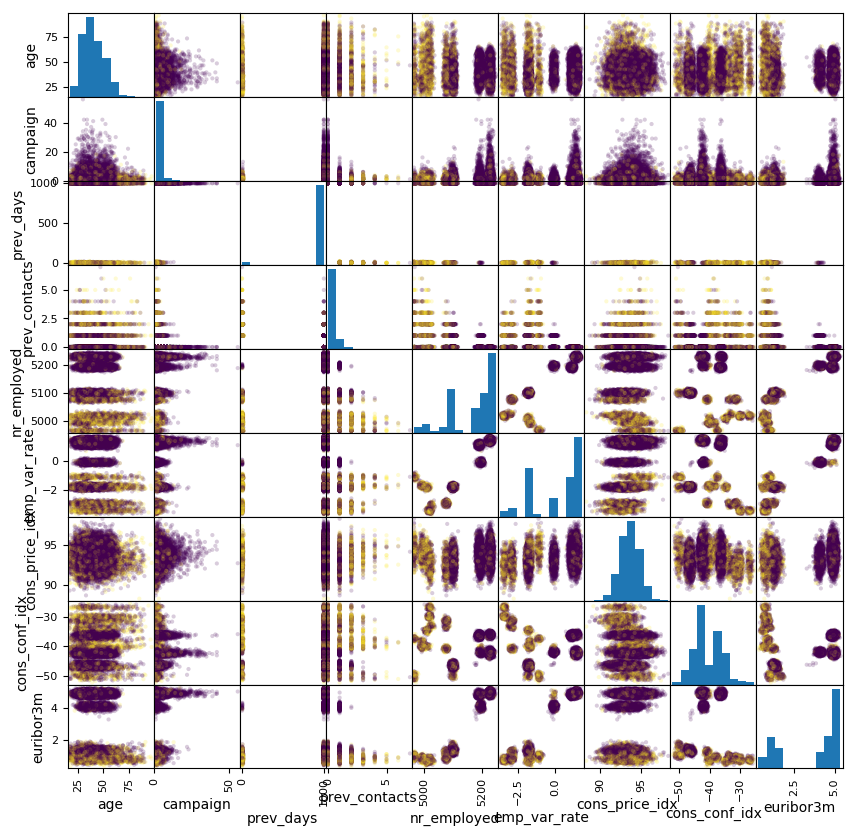

In [34]:
pd.tools.plotting.scatter_matrix(X_train[continuous], c=y_train, alpha=.2, figsize=(10, 10));

A few observations we see from the scatter matrix above:

- majority of clients are in their 30's (age).
- negative correlation between nr_employed and prev_contacts: clients with less number of employees tend to receive higher number of contacts before a specific campaign
- those who are younger (age) tends to have higher number of employees (nr_employed)

#### Density Plots

We also used density plots below to visualize the distribution of those who subscribed and those who did not subscribed (y-axis) for each continuous variable (x-axis). The kernel gaussian density is used to draw inferences about the population of those who subscribed vs. those who didn't.

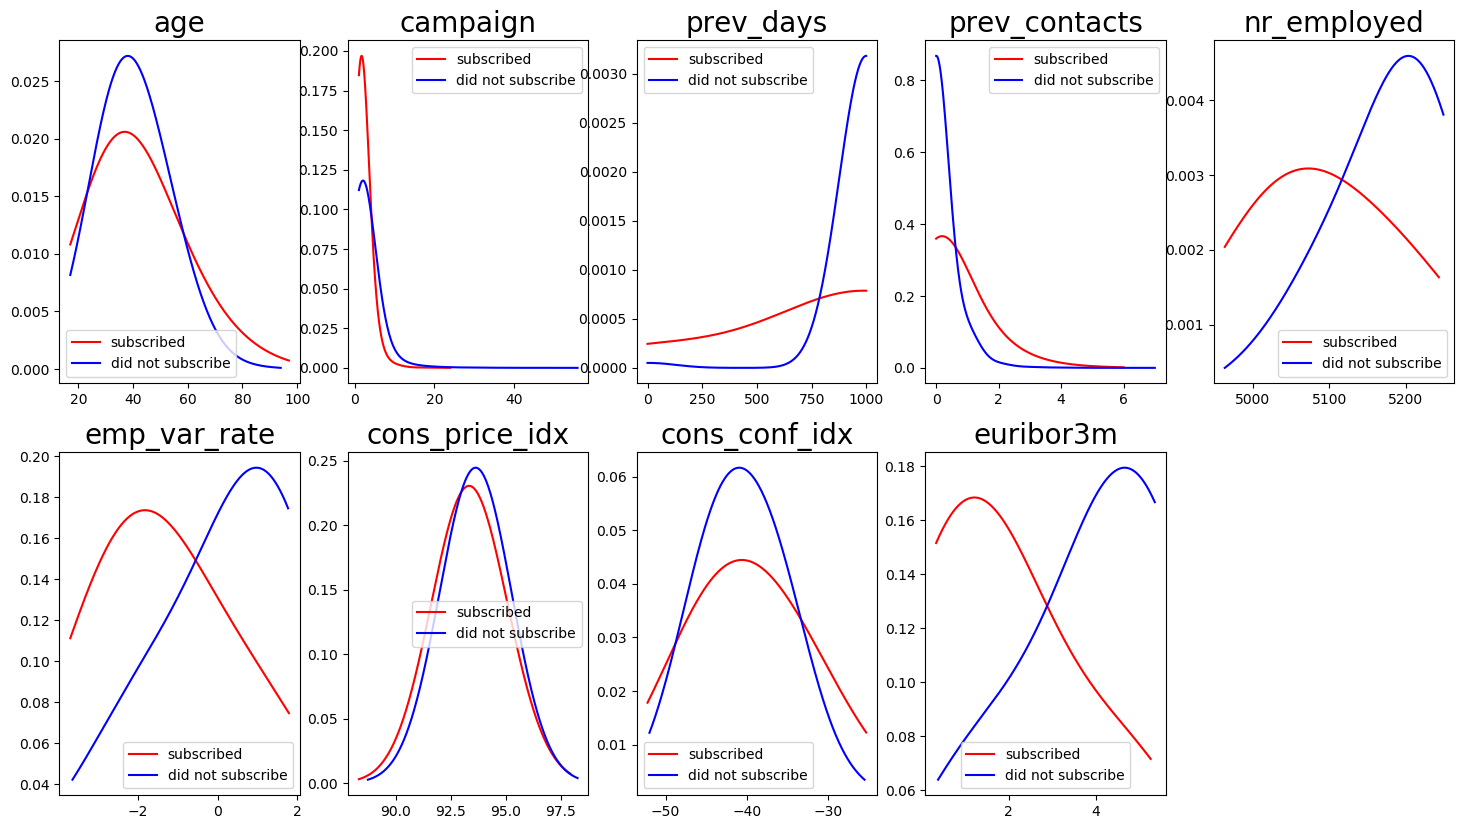

In [35]:
from scipy.stats import gaussian_kde

def density_calc(array, N = 500, bw = 0.2):
    """
    Parameters
    ----------
    array   :       array-like, data to be plotted as density
    N       :       int, number of points to use to generate density curve
    bw      :       float, corresponds to bandwidth, smaller results in skinnier bands.  
                    larger value results in wider bands
    Outputs
    -------
    x       :      array created from np.linspace
    density :      points of the density curve created with scipy.stats.gaussian_kde
    """
    density = gaussian_kde(array)
    x = np.linspace(np.min(array), np.max(array), N)
    density.covariance_factor = lambda: bw
    density._compute_covariance()
    return x, density(x)

def plot_density(values, bw = 0.2, N = 500):
    """
    Parameters
    ----------
    values       :       list, corresponds to columns in data table to plot
    bw           :       float, bandwidth parameter to be given to density_calc
    N            :       int, number of points used to generate density in density_calc    
    categorical  :       if data is categorical, ie non-integer/non-float then
                         create integer dummy variables
    Output
    ------
    Array of plots for density functions
    """
    df = data.copy() 
    fig = plt.figure(figsize=(2*len(values),10))
    for i,value in enumerate(values):
        axes = fig.add_subplot(2, len(values)/2+1, i+1)
        
        x, y = density_calc(df[str(value)][df["subscribed"] == "yes"], bw = bw)
        axes.plot(x, y, 'r', label='subscribed')

        x, y = density_calc(df[str(value)][df["subscribed"] == "no"], bw = bw)
        axes.plot(x, y, 'b', label='did not subscribe')
        axes.legend()
        axes.set_title(value)
        axes.title.set_fontsize(20)
    plt.show()
    
plot_density(continuous, bw=1)

Observations from the density plot above indicate that clients were less likely to subscribe when they had:

- higher the number of employees (nr_employed)
- higher the employment variation rate (emp_var_rate)
- higher euribor 3-month rate (euribor3m)

It's also interesting to see that in campaign, age, and cons_price_idx (consumer price index), the behaviors of clients who are likely to subscribe and not subcribe are quite similar.

#### Histograms

To observe the variables further, we can use histogram as follows.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000016430D68>,
      dtype=object)

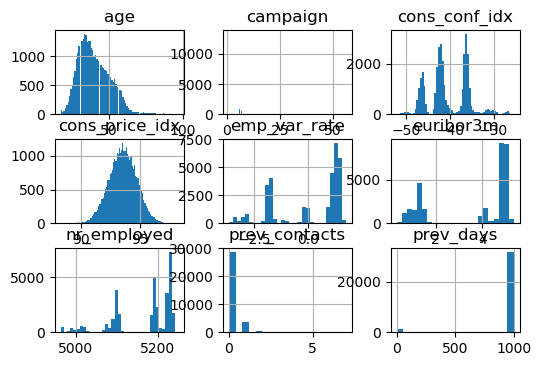

In [36]:
data_.hist(bins='auto')

Some observations can also be drawn:

- most data points in prev_days represent 999 values, which mean means most clients were not previously contacted
- cons_price_idx looks normally distributed
- age distribution looks right-skewed
- cons_conf_idx has three modes (trimodal distribution)
- interesting pattern in prev_contacts
- left skewed distribution with large gaps in nr_employed

### 1.2. Convert yes/no values to 1/0

First, we encode 1 for all categorical variables with yes values and 0 for no values.

In [37]:
def replace_non_numeric(df):
    df1 = df.copy()
    yn_vars = ['credit_default', 'housing', 'loan']

    for dummy in yn_vars:
        df1[dummy] = df1[dummy].apply(lambda item: 0 if item == 'no' else item)
        df1[dummy] = df1[dummy].apply(lambda item: 1 if item == 'yes' else item)
        
    return df1

X_train_1 = replace_non_numeric(X_train)
X_test_1 = replace_non_numeric(X_test)

In [38]:
X_train_1.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
12353,52.0,blue-collar,married,basic.4y,NaN,0.0,0.0,telephone,may,thu,15.0,999,0,nonexistent,1.178261,94.236694,-37.048583,4.746075,5192.0
29303,41.0,blue-collar,single,basic.6y,NaN,1.0,0.0,cellular,apr,fri,4.0,999,1,failure,-2.000945,94.103725,-46.096535,1.427209,5096.0
2965,36.0,entrepreneur,single,university.degree,0.0,1.0,0.0,telephone,jun,fri,1.0,999,0,nonexistent,1.331550,94.790008,-41.728380,4.990515,5227.0
26504,46.0,blue-collar,divorced,NaN,0.0,0.0,0.0,cellular,jul,tue,8.0,999,0,nonexistent,1.335875,94.525150,-42.931450,5.070245,5233.0
23299,51.0,management,married,university.degree,0.0,1.0,0.0,telephone,jun,fri,3.0,999,0,nonexistent,1.468371,94.173802,-42.645052,5.113962,5228.0


In [39]:
X_test_1.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
8475,39.0,self-employed,married,high.school,0.0,0.0,0.0,telephone,may,fri,8.0,999,0,nonexistent,1.005332,95.566634,-36.189834,4.941764,5193.0
25420,47.0,entrepreneur,married,basic.4y,NaN,0.0,0.0,cellular,aug,thu,1.0,999,0,nonexistent,1.403108,93.184728,-36.516203,4.844983,5231.0
954,53.0,housemaid,married,basic.4y,NaN,0.0,1.0,cellular,jul,wed,3.0,999,0,nonexistent,1.493933,93.452199,-42.725579,5.034550,5224.0
31356,36.0,blue-collar,married,high.school,NaN,1.0,0.0,cellular,jul,tue,1.0,999,0,nonexistent,1.248770,93.930201,-42.320884,4.790487,5226.0
28161,60.0,blue-collar,married,basic.9y,NaN,0.0,0.0,cellular,jul,fri,1.0,999,0,nonexistent,1.322459,93.690272,-42.332641,4.812160,5230.0


### 1.3. Create dummies for categorical variables

We can now perform one-hot-encoding technique to create dummies for other categorical variables. We perform one-hot-encoding to data containing both training and test set to ensure categorical variables are represented in the same way in both of these sets.

In [40]:
X_train = pd.get_dummies(X_train_1)
X_test = pd.get_dummies(X_test_1)

column_names = X_train.columns

print("Size for X_train:", X_train.shape)
print("Size for X_test:", X_test.shape)

('Size for X_train:', (24712, 53))
('Size for X_test:', (8238, 53))


In [41]:
X_train.head()

,age,credit_default,housing,loan,campaign,prev_days,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,prev_outcomes_failure,prev_outcomes_nonexistent,prev_outcomes_success
12353,52.0,NaN,0.0,0.0,15.0,999,0,1.178261,94.236694,-37.048583,...,0,0,0,0,1,0,0,0,1,0
29303,41.0,NaN,1.0,0.0,4.0,999,1,-2.000945,94.103725,-46.096535,...,0,0,1,0,0,0,0,1,0,0
2965,36.0,0.0,1.0,0.0,1.0,999,0,1.331550,94.790008,-41.728380,...,0,0,1,0,0,0,0,0,1,0
26504,46.0,0.0,0.0,0.0,8.0,999,0,1.335875,94.525150,-42.931450,...,0,0,0,0,0,1,0,0,1,0
23299,51.0,0.0,1.0,0.0,3.0,999,0,1.468371,94.173802,-42.645052,...,0,0,1,0,0,0,0,0,1,0


### 1.4. Create binary prev_days indicator

Due to high volume of '999' entries for the prev_days versus the other entries, we decided to create a dummy variable not_contacted indicating 1 if pre_days are 999 else 0.

In [43]:
X_train['not_contacted'] = X_train['prev_days'].apply(lambda item: 1 if item == 999 else 0)
X_test['not_contacted'] = X_test['prev_days'].apply(lambda item: 1 if item == 999 else 0)

### 1.5. Impute missing values

With our split dataset, we want to impute missing data for variables containing null values. Three variables with missing values below will be imputed.

In [44]:
X_train.isnull().any()

age                              False
credit_default                    True
housing                           True
loan                              True
campaign                         False
prev_days                        False
prev_contacts                    False
emp_var_rate                     False
cons_price_idx                   False
cons_conf_idx                    False
euribor3m                        False
nr_employed                      False
job_admin.                       False
job_blue-collar                  False
job_entrepreneur                 False
job_housemaid                    False
job_management                   False
job_retired                      False
job_self-employed                False
job_services                     False
job_student                      False
job_technician                   False
job_unemployed                   False
marital_status_divorced          False
marital_status_married           False
marital_status_single    

Check counts on features with missing values:

In [45]:
null_features = X_train.isnull().any()

for i in range(len(null_features)):
    if null_features[i]:
        print(X_train[X_train.columns[i]].isnull().value_counts())

False    19572
True      5140
Name: credit_default, dtype: int64
False    24122
True       590
Name: housing, dtype: int64
False    24122
True       590
Name: loan, dtype: int64


We see that all missing values are in categorical variables, so we can perform Imputer's **most frequent** strategy. Some observation: education and marital_status variables have larger number of missing values.

In [46]:
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(X_train)
X_test = pd.DataFrame(imp.transform(X_test))
X_train = pd.DataFrame(imp.transform(X_train))

C:\Users\ketul\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [47]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,52.0,0.0,0.0,0.0,15.0,999.0,0.0,1.178261,94.236694,-37.048583,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,41.0,0.0,1.0,0.0,4.0,999.0,1.0,-2.000945,94.103725,-46.096535,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,36.0,0.0,1.0,0.0,1.0,999.0,0.0,1.331550,94.790008,-41.728380,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,46.0,0.0,0.0,0.0,8.0,999.0,0.0,1.335875,94.525150,-42.931450,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,51.0,0.0,1.0,0.0,3.0,999.0,0.0,1.468371,94.173802,-42.645052,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### 1.6. Pick significant variables

Using mutual_info_classif, we pick our best features down to 27 variables from 53 variables, using 'feature 12' below as our cutoff.

(0, 54)

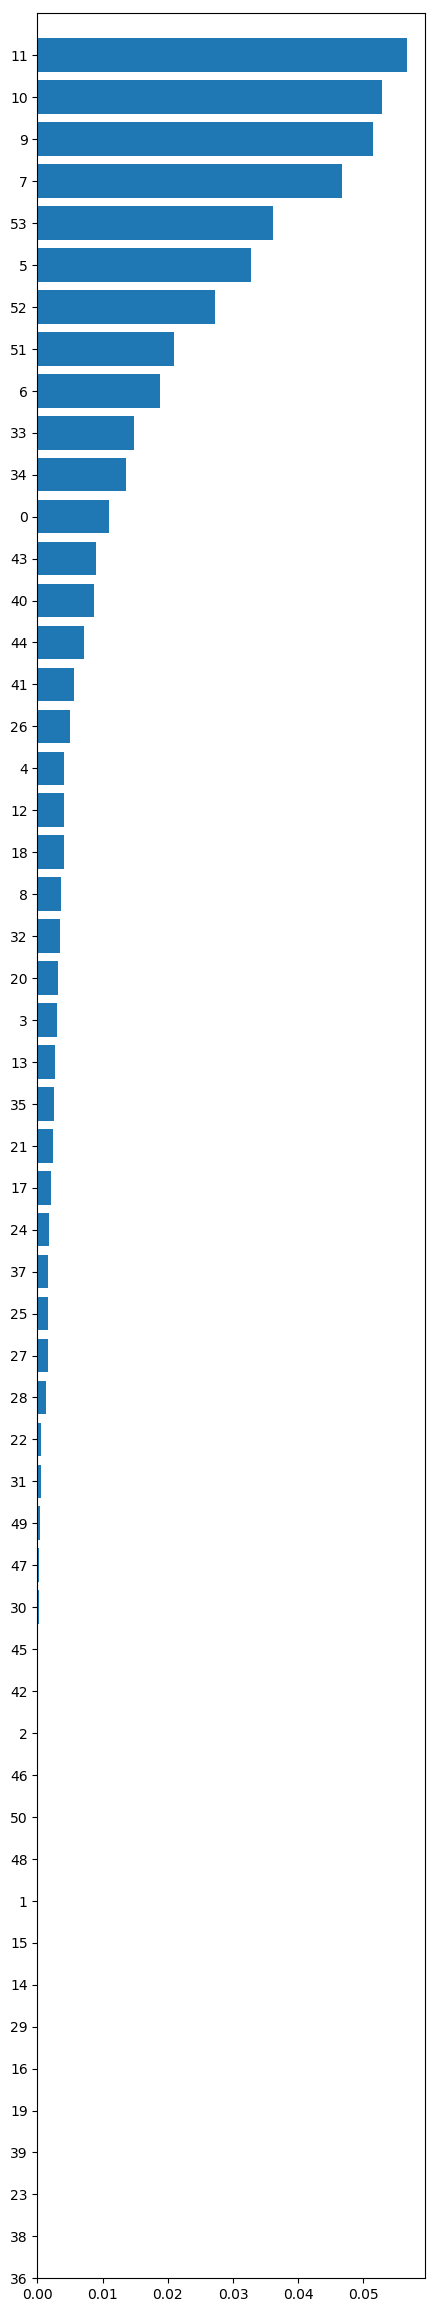

In [48]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X_train, y_train.values)
inds = np.argsort(mi)

plt.figure(figsize=(5, 30))
plt.barh(np.arange(len(mi)), np.log(mi[inds] + 1))
plt.yticks(np.arange(len(mi)), X_train.columns[inds])
plt.ylim(0, len(mi))

In [49]:
# only take the significant variables (cut from 53 to 40 columns)
cutoff = int(np.where( inds == 12 )[0])
length = len(inds)
keep_inds = inds[-(length-cutoff):]

In [50]:
X_train[keep_inds].head()

,12,4,26,41,44,40,43,0,34,33,6,51,52,5,53,7,9,10,11
0,0.0,15.0,1.0,1.0,0.0,0.0,0.0,52.0,1.0,0.0,0.0,1.0,0.0,999.0,1.0,1.178261,-37.048583,4.746075,5192.0
1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,1.0,1.0,0.0,0.0,999.0,1.0,-2.000945,-46.096535,1.427209,5096.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,36.0,1.0,0.0,0.0,1.0,0.0,999.0,1.0,1.331550,-41.728380,4.990515,5227.0
3,0.0,8.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,1.0,0.0,1.0,0.0,999.0,1.0,1.335875,-42.931450,5.070245,5233.0
4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,51.0,1.0,0.0,0.0,1.0,0.0,999.0,1.0,1.468371,-42.645052,5.113962,5228.0


(0, 19)

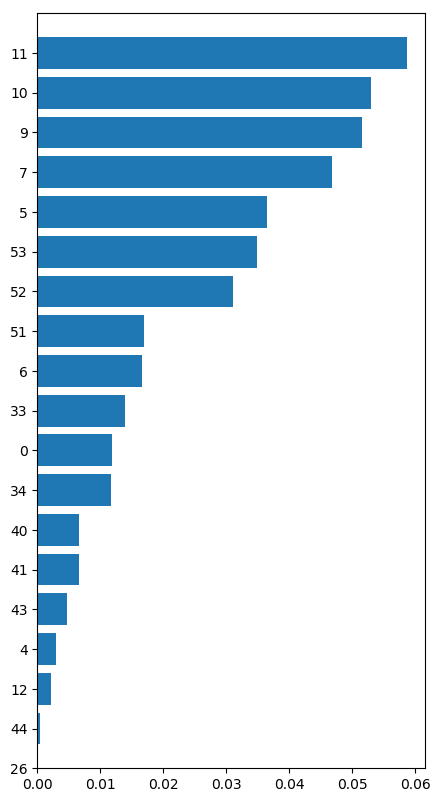

In [51]:
mi_new = mutual_info_classif(X_train[keep_inds], y_train.values)
inds_new = np.argsort(mi_new)

plt.figure(figsize=(5, 10))
plt.barh(np.arange(len(mi_new)), np.log(mi_new[inds_new] + 1))
plt.yticks(np.arange(len(mi_new)), X_train[keep_inds].columns[inds_new])
plt.ylim(0, len(mi_new))

In [52]:
# important features to keep:
keep_inds

array([12,  4, 26, 41, 44, 40, 43,  0, 34, 33,  6, 51, 52,  5, 53,  7,  9,
       10, 11], dtype=int64)

In [53]:
X_train = X_train[keep_inds]
X_test = X_test[keep_inds]

In [54]:
X_train.head() # 27 columns

,12,4,26,41,44,40,43,0,34,33,6,51,52,5,53,7,9,10,11
0,0.0,15.0,1.0,1.0,0.0,0.0,0.0,52.0,1.0,0.0,0.0,1.0,0.0,999.0,1.0,1.178261,-37.048583,4.746075,5192.0
1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,1.0,1.0,0.0,0.0,999.0,1.0,-2.000945,-46.096535,1.427209,5096.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,36.0,1.0,0.0,0.0,1.0,0.0,999.0,1.0,1.331550,-41.728380,4.990515,5227.0
3,0.0,8.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,1.0,0.0,1.0,0.0,999.0,1.0,1.335875,-42.931450,5.070245,5233.0
4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,51.0,1.0,0.0,0.0,1.0,0.0,999.0,1.0,1.468371,-42.645052,5.113962,5228.0


We now have 27 columns.

### 1.7. Deal with imbalanced data

In [55]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.89


We see here that even without any models, we would get 0.89 of accuracy. Although it seems to be a very good performance, the accuracy is only reflecting the underlying class distribution -- therefore the data is imbalanced. There is actually far too many datapoints in [0] class than [1] class. So the problem that may come up is that the model we perform can always predict the majority class, in this case [0].

We will deal with imbalanced data using undersampling, oversampling, and resampled ensemble in the next steps.

#### Undersample

- Random Undersampling

In [56]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(24712, 19)
(5568L, 19L)
[2784 2784]


- Using Pipeline for Undersampling

In [57]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_val_score(undersample_pipe, X_train, y_train, cv=10, scoring = 'roc_auc')
print(np.mean(scores), scores)

C:\Users\ketul\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\ketul\Anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(0.7783714634083834, array([0.811, 0.775, 0.748, 0.78 , 0.773, 0.769, 0.765, 0.802, 0.797,
       0.762]))


#### Oversample

- Random Oversampling

In [58]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(24712, 19)
(43856L, 19L)
[21928 21928]


- Using Pipeline for Oversampling

In [59]:
from sklearn.linear_model import LogisticRegression
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegressionCV())
scores = cross_val_score(oversample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores), scores)

(0.7796792788575486, array([0.81 , 0.773, 0.753, 0.778, 0.775, 0.775, 0.768, 0.801, 0.8  ,
       0.765]))


- Synthetic Minority Over-sampling (SMOTE)

In [60]:
from imblearn import over_sampling, under_sampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.1, 0.9], n_informative=3, 
                           n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, 
                           n_samples=1000, random_state=10)

print('Original dataset shape {}'.format(Counter(y)))

#sm_pipe = make_imb_pipeline(SMOTE(random_state = 42), classifier)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({False: 21928, True: 21928})


## Step 2 - Classification Models

We start building our model by first using classification algorithms apart from tree-based models. The following steps are included as part of our model building.

- feature engineering
- validation
- feature selection
- final model selection

In [ ]:
#SVM, Logistic Regression, try to minimize covariance between models ie pick up on specific features unique to model

In [116]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE 

from collections import Counter
from sklearn.datasets import make_classification

### 2.1. Logistic Regression

For logistic regression, we used PolynomialFeatures to create more features in the model, which had a higher score than having an additional feature selection such as SelectPercentile. We also used MinMaxScaler to subtract minimum and divide by range. Afterwards between 0 and 1. RandomUnderSampler was used to deal with imbalanced data. We evaluated our model using cross validations with cv = 5.

In [62]:
from sklearn.preprocessing import PolynomialFeatures
start = time.clock()

param_grid = {'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10, 100]}

us_lr = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), PolynomialFeatures(include_bias=False), LogisticRegression())

scores = cross_val_score(us_lr, X_train, y_train, cv=10, scoring = 'roc_auc')
print(scores)

grid_search_lr = GridSearchCV(us_lr, param_grid, cv=5, scoring='roc_auc')
grid_search_lr.fit(X_train, y_train)

end = time.clock()

print("Accuracy on training set: {:.2f}".format(grid_search_lr.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(grid_search_lr.score(X_test, y_test)))
print(grid_search_lr.best_params_)

print("Execution time:",str(float(end-start)),"seconds.")

C:\Users\ketul\Anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.811 0.792 0.762 0.799 0.79  0.776 0.771 0.807 0.815 0.775]
Accuracy on training set: 0.80
Accuracy on test set: 0.81
{'logisticregression__C': 10}
('Execution time:', '15.4442453337', 'seconds.')


### 2.2. Linear SVM

We used SelectPercentile to select a fixed percentage of features and RobustScaler to subtract minimum and divide by range. Afterwards between 0 and 1. RandomUnderSample was used to deal with imbalanced data.

In [63]:
from sklearn.feature_selection import SelectPercentile, f_classif
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

X_train.shape: (24712, 19)
X_train_selected.shape: (24712L, 9L)


In [64]:
#Timed to 0.113 minutes to fit per model w/ full dataset

#l1 penalty not supported using dual optimization due to non-convexity
start = time.clock()

param_grid = {'linearsvc__C': [0.001, 0.01, 0.1, 1, 10, 100]}

us_lsvc = make_imb_pipeline(RandomUnderSampler(), RobustScaler(), LinearSVC())

scores = cross_val_score(us_lsvc, X_train_selected, y_train, cv=10, scoring = 'roc_auc')
print(scores)

grid_search = GridSearchCV(us_lsvc, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_selected, y_train)

end = time.clock()

print("Accuracy on training set: {:.2f}".format(grid_search.score(X_train_selected, y_train)))
print("Accuracy on test set: {:.2f}".format(grid_search.score(X_test_selected, y_test)))
print(grid_search.best_params_)

print("Execution time:",str(float(end-start)),"seconds.")

C:\Users\ketul\Anaconda2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.799 0.764 0.61  0.785 0.761 0.754 0.768 0.806 0.8   0.753]
Accuracy on training set: 0.78
Accuracy on test set: 0.79
{'linearsvc__C': 0.01}
('Execution time:', '13.9579594343', 'seconds.')


### 2.3. Kernelized SVM (RBF)

Here we wanted to see if kernelized SVM would do better than the linear SVM, so we ran a quick roc_auc score testing for comparison purposes.

In [65]:
pipe_rbf = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), SVC(probability=True))

grid = GridSearchCV(pipe_rbf, cv=10, param_grid = {}, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train), '\n', grid.score(X_test, y_test))
score = cross_val_score(pipe_rbf, X_train, y_train, cv=10, scoring = 'roc_auc')
print(scores, '\n', np.mean(scores))

C:\Users\ketul\Anaconda2\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(0.7767074591295651, '\n', 0.7923354285579508)
(array([0.799, 0.764, 0.61 , 0.785, 0.761, 0.754, 0.768, 0.806, 0.8  ,
       0.753]), '\n', 0.7598555158936733)


### 2.4. Naive Bayes

In [66]:
pipe_nb = make_imb_pipeline(RandomUnderSampler(), StandardScaler(), GaussianNB())
scores = cross_val_score(pipe_nb, X_train_selected, y_train, cv=10)
print(np.mean(scores))

scores = cross_val_score(pipe_nb, X_train, y_train, cv=10)
print(np.mean(scores)) 

0.8377296106157237
0.8673923084473684


### 2.5. Stochastic Gradient Descent Classifier

We used SelectPercentile to select a fixed percentage of features and RobustScaler to subtract minimum and divide by range. Afterwards between 0 and 1. RandomUnderSample was used to deal with imbalanced data. We evaluated our model using cross validations with cv = 10.

In [67]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

X_train.shape: (24712, 19)
X_train_selected.shape: (24712L, 9L)


In [68]:
from sklearn.utils import gen_batches, shuffle
from sklearn.linear_model import SGDClassifier

batches = [(X_train_selected[batch], y_train[batch]) for batch in gen_batches(X_train.shape[0], 10)]

sgd = SGDClassifier(loss = 'modified_huber')
for i in range(10):
    for X_batch, y_batch in batches:
        sgd.partial_fit(X_batch, y_batch, classes=[0, 1, 2])
sgd.score(X_test_selected, y_test)

sgd_params = {'sgdclassifier__penalty': ['elasticnet', 'l1', 'l2'], 
              'sgdclassifier__loss': ['modified_huber']}
sgd_pipe = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), SGDClassifier())

grid = GridSearchCV(sgd_pipe, sgd_params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

print(grid.score(X_train, y_train))
print(grid.score(X_test, y_test))
print(grid.best_params_)

C:\Users\ketul\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.7026180509252853
0.7130380560403793
{'sgdclassifier__penalty': 'l2', 'sgdclassifier__loss': 'modified_huber'}


### 2.6. Nearest Centroid Classifier

We used SelectKBest to select a fixed percentage of features and RobustScaler to subtract minimum and divide by range. Afterwards between 0 and 1. RandomUnderSample was used to deal with imbalanced data. Note that although this evaluates as a good model, we won't be using nearest centroid classifier since it does not have predict_proba function.

In [71]:
from sklearn.feature_selection import SelectKBest
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectKBest(k='all')
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

X_train.shape: (24712, 19)
X_train_selected.shape: (24712L, 19L)


In [72]:
start = time.clock()

param_grid = {'nearestcentroid__metric': ['manhattan', 'euclidean'],
              'nearestcentroid__shrink_threshold': [None, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,1000.0]}

rus_sc = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), NearestCentroid())

grid_search = GridSearchCV(rus_sc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

end = time.clock()

print("Accuracy on training set: {:.2f}".format(grid_search.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(grid_search.score(X_test, y_test)))
print(grid_search.best_params_)

print("Execution time:",str(float(end-start)),"seconds.")

Accuracy on training set: 0.89
Accuracy on test set: 0.89
{'nearestcentroid__shrink_threshold': 100.0, 'nearestcentroid__metric': 'manhattan'}
('Execution time:', '2.97138997192', 'seconds.')


### 2.7. Logistic Regression with Resampled Ensemble

Feature engineering includes adding PolynomialFeatures with bias and interactions, soft voting, StandardScaler, and also resampled ensemble. We validated our models using cross_val_score with cv=5.

In [111]:
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier

def make_resampled_ensemble(estimator, n_estimators=10):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state=i, replacement=True),
                                 StandardScaler(), PolynomialFeatures(include_bias=False, interaction_only=True),
                                 est)
        estimators.append(("est_%s)"%(i), pipe))
    return VotingClassifier(estimators, voting="soft")
resampled_lr = make_resampled_ensemble(LogisticRegression(C=1))
scores = cross_val_score(resampled_lr, X_train, y_train, cv=5, scoring='roc_auc')
print(np.mean(scores))
resampled_lr.fit(X_train,y_train)

0.7876070019920292


VotingClassifier(estimators=[('est_0)', Pipeline(memory=None,
     steps=[('randomundersampler', RandomUnderSampler(random_state=0, ratio=None, replacement=True,
          return_indices=False, sampling_strategy='auto')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatu...penalty='l2', random_state=9, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [114]:
print("ROC-AUC score on training set: {:.2f}".format(resampled_lr.score(X_train, y_train)))
print("ROC-AUC score on test set: {:.2f}".format(resampled_lr.score(X_test, y_test)))

ROC-AUC score on training set: 0.82
ROC-AUC score on test set: 0.82


### 2.8. Logistic Regression with RFE

For logistic regression, we used PolynomialFeatures to create more features in the model, which had a higher score than having an additional feature selection such as SelectPercentile. We also used MinMaxScaler to subtract minimum and divide by range. Afterwards between 0 and 1. RandomUnderSampler was used to deal with imbalanced data.

In [117]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
n_features_to_select=40)
select.fit(X_train, y_train)

X_train_rfe= select.transform(X_train)
X_test_rfe= select.transform(X_test)

In [120]:
start = time.clock()

param_grid = {'logisticregression__C' : [0.01, 0.1, 1, 10]}

us_lr_rfe = make_imb_pipeline(RandomUnderSampler(random_state=2), MinMaxScaler(), PolynomialFeatures(), LogisticRegression(random_state=42))
scores = cross_val_score(us_lr, X_train_rfe, y_train, cv=10, scoring = 'roc_auc')
print(scores)

grid_search = GridSearchCV(us_lr_rfe, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_rfe, y_train)

end = time.clock()

print("ROC-AUC score on training set: {:.2f}".format(grid_search.score(X_train_rfe, y_train)))
print("ROC-AUC score on test set: {:.2f}".format(grid_search.score(X_test_rfe, y_test)))
print(grid_search.best_params_)

print("Execution time:",str(float(end-start)),"seconds.")

[0.813 0.788 0.754 0.794 0.794 0.779 0.773 0.81  0.814 0.779]
ROC-AUC score on training set: 0.80
ROC-AUC score on test set: 0.81
{'logisticregression__C': 1}
('Execution time:', '10.6627628621', 'seconds.')


### 2.9. Logistic Regression with RFE Lasso

For logistic regression, we used PolynomialFeatures to create more features in the model, which had a higher score than having an additional feature selection such as SelectPercentile. We also used MinMaxScaler to subtract minimum and divide by range. Afterwards between 0 and 1. RandomUnderSampler was used to deal with imbalanced data. We performed evaluation using cross validations but apparently the resampled ensemble technique for linear regression outperforms the score.

In [121]:
from sklearn.linear_model import Lasso
select = RFE(Lasso(alpha=0.1))
select.fit(X_train, y_train)

X_train_rfe= select.transform(X_train)
X_test_rfe= select.transform(X_test)

make_imb_pipeline(RFE(Lasso(alpha=0.1)), LogisticRegression(C=0.1))

Pipeline(memory=None,
     steps=[('rfe', RFE(estimator=Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=None, step=1, verbose=0)), ('logisticregression', Logist...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [123]:
start = time.clock()

param_grid = {'logisticregression__C' : [0.01, 0.1, 1, 10]}

us_lr_rfe = make_imb_pipeline(RandomUnderSampler(random_state=2), MinMaxScaler(), PolynomialFeatures(), LogisticRegression(random_state=42))

scores = cross_val_score(us_lr_rfe, X_train_rfe, y_train, cv=10, scoring = 'roc_auc')
print(scores)

grid_search = GridSearchCV(us_lr_rfe, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_rfe, y_train)

end = time.clock()

print("ROC-AUC score on training set: {:.2f}".format(grid_search.score(X_train_rfe, y_train)))
print("ROC-AUC score on test set: {:.2f}".format(grid_search.score(X_test_rfe, y_test)))
print(grid_search.best_params_)

print("Execution time:",str(float(end-start)),"seconds.")

[0.797 0.77  0.757 0.781 0.784 0.752 0.766 0.799 0.803 0.765]
ROC-AUC score on training set: 0.78
ROC-AUC score on test set: 0.80
{'logisticregression__C': 10}
('Execution time:', '3.34822624018', 'seconds.')


### 2.10. Final Model from Set 1: Logistic Regression with Resampled Ensemble

We see from many trials that our best model is Logistic Regression with Resampled Ensemble, with both training and test set roc-auc scores of 0.83. We chose only one model because it ended up being our best score for the stacking ensemble, compared to having different models at the same time. We will now evaluate the ROC area under curve.

**FPR**=FPFP+TN
(False Positive Rate) **TPR**=TPTP+FN

(True Positive Rate)

ROC AUC score is the area under the ROC curve where TPR (y-axis) is plotted against FPR (x-axis), which in our caes is 0.83. The **ROC curve** plotted below considers all possible threshold for the logistic regression we chose, having FPR and TPR as primary scoring metrics. The curve below shows that we can achieve a significantly higher recall around 0.6 while only increasing the FPR slightly. The ideal curve is close to the top left, having a high recall and a low false positive rate.


No handlers could be found for logger "matplotlib.legend"


Text(0,0.5,u'TPR')

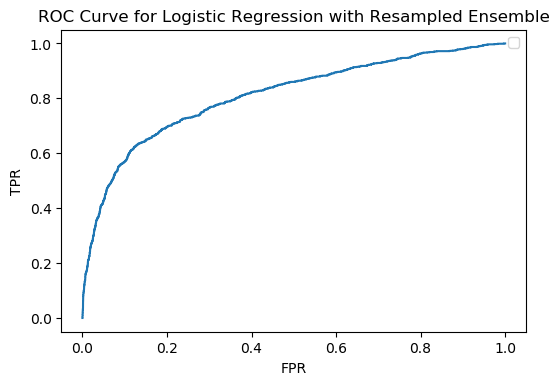

In [124]:
from sklearn.metrics import roc_curve

props_original = resampled_lr.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, props_original)

plt.plot(fpr_org, tpr_org)
plt.legend()
plt.title("ROC Curve for Logistic Regression with Resampled Ensemble")
plt.xlabel("FPR")
plt.ylabel("TPR")

## Step 3 - Tree-based Models

We will also use the following steps for improving our models.

- feature engineering
- validation
- feature selection
- final model selection

In [125]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

### 3.1. Decision Tree

We begin with decision tree technique, where our feature selection is SelectPercentile of the top 60% and we used both random under sampler and MinMaxScaler to modify our function. We were able to tune hyperparameter multiple times even after grid search, and our decision tree classifier's best parameters are finalized to have gini criterion and max_leaf_nodes of 10. We evaluated our model with cross validations with cv=5. Our overall score is no better than that of linear model using logisitic regression.

In [126]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=60)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))# transform test data
X_test_selected = select.transform(X_test)

X_train.shape: (24712, 19)
X_train_selected.shape: (24712L, 11L)


In [127]:
param_grid_dtc = {'decisiontreeclassifier__criterion':['gini', 'entropy'],
                  'decisiontreeclassifier__max_leaf_nodes': [None, 2, 4, 6, 8, 10, 50],
                  'decisiontreeclassifier__max_depth':[None, 10, 50]}


pipe_rtt = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), DecisionTreeClassifier())

grid = GridSearchCV(pipe_rtt, param_grid = param_grid_dtc, cv=5, scoring = 'roc_auc')
grid.fit(X_train_selected, y_train)
print(grid.best_params_)
print(grid.score(X_train_selected, y_train))
print(grid.score(X_test_selected, y_test))

{'decisiontreeclassifier__max_leaf_nodes': 10, 'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__criterion': 'entropy'}
0.7826964789677398
0.7993420237982923


### 3.2. Random Forest

For Random Forest, we use RFE classifier as an interative feature selection. For feature selection, we use SelectPercentile. We also use RandomUnderSampler to deal with imbalanced data and tried RobustScaler. Our model performance with random forest classifier is better than decision tree. We were able to evaluate the model using cross validations with cv=10, yielding a training score of 0.79 and test score of 0.80.

In [128]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

X_train.shape: (24712, 19)
X_train_selected.shape: (24712L, 9L)


In [129]:
param_grid_RF = { "randomforestclassifier__n_estimators": [100],
           "randomforestclassifier__criterion"          : ["gini", "entropy"],
           "randomforestclassifier__max_depth"          : [5,10],
           "randomforestclassifier__min_samples_split"  : [3,2] ,
           "randomforestclassifier__bootstrap"          : [True, False]}

rus = make_imb_pipeline(RandomUnderSampler(), RobustScaler(), RandomForestClassifier(random_state=2))

grid_search_RF = GridSearchCV(rus, param_grid_RF, n_jobs=-1, cv=10, scoring="roc_auc")
grid_search_RF.fit(X_train_selected, y_train)
print(grid_search_RF.best_params_)

print("ROC-AUC score on training set: {:.2f}".format(grid_search_RF.score(X_train_selected, y_train)))
print("ROC-AUC score on test set: {:.2f}".format(grid_search_RF.score(X_test_selected, y_test)))

# You improved on your best score by 0.00424.

{'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__bootstrap': False}
ROC-AUC score on training set: 0.80
ROC-AUC score on test set: 0.81


### 3.3. Bagging

For bagging, we use SelectPercentile, RandomUnderSampler and MinMaxScaler. Our model performance with random forest classifier is better than decision tree. We were able to evaluate the model using cross validations with cv=10, yielding a training score of 0.97 and test score of 0.77. We see that the model is overfitting so we will not use this model.

In [130]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=60)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

X_train.shape: (24712, 19)
X_train_selected.shape: (24712L, 11L)


In [131]:
'''
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5, random_state=2)

param_grid = {"baggingclassifier__n_estimators" : range(5,25,10)}

rus = make_imb_pipeline(RandomOverSampler(), MinMaxScaler(), bagging)

grid = GridSearchCV(rus, param_grid=param_grid, cv=10, scoring = 'roc_auc')
grid.fit(X_train_selected, y_train)

print("ROC-AUC score on training set: {:.2f}".format(grid.score(X_train_selected, y_train)))
print("ROC-AUC score on test set: {:.2f}".format(grid.score(X_test_selected, y_test)))
'''

'\nbagging = BaggingClassifier(KNeighborsClassifier(),\n                            max_samples=0.5, max_features=0.5, random_state=2)\n\nparam_grid = {"baggingclassifier__n_estimators" : range(5,25,10)}\n\nrus = make_imb_pipeline(RandomOverSampler(), MinMaxScaler(), bagging)\n\ngrid = GridSearchCV(rus, param_grid=param_grid, cv=10, scoring = \'roc_auc\')\ngrid.fit(X_train_selected, y_train)\n\nprint("ROC-AUC score on training set: {:.2f}".format(grid.score(X_train_selected, y_train)))\nprint("ROC-AUC score on test set: {:.2f}".format(grid.score(X_test_selected, y_test)))\n'

### 3.4. Gradient Boosting

After trying out several resampling techniques, we decided to use resampled ensemble for our gradient boosting below. The pipeline involves adding polynomial features with bias and interactions and scaling the data using StandardScaler. With the score below being the highest among other techniques, we found our best model for this set using gradient boosting.

In [134]:
def make_resampled_ensemble_tree(estimator, n_estimators=10):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state=i, replacement=True),
                                 StandardScaler(), PolynomialFeatures(include_bias=False, interaction_only=True),
                                 est)
        estimators.append(("est_%s"%(i), pipe))
    return VotingClassifier(estimators, voting="soft")

In [135]:
gbrt = make_imb_pipeline(make_resampled_ensemble_tree(GradientBoostingClassifier(max_depth = 6, random_state=2)))
gbrt.fit(X_train, y_train)
gbrt.score(X_test, y_test)

y_score = pd.DataFrame(gbrt.predict_proba(X_train))[1]
print("ROC-AUC score on training set:", roc_auc_score(y_train, y_score))

y_score = pd.DataFrame(gbrt.predict_proba(X_test))[1]
print("ROC-AUC score on test set:", roc_auc_score(y_test, y_score))

('ROC-AUC score on training set:', 0.9187087796739173)
('ROC-AUC score on test set:', 0.8025515649323082)


### 3.5. Adaboost

We use SelectPercentile, RandomUnderSampler and MinMaxScaler to execute this technique. The Adaboost performs similarly to the Random Forest classifier approach, where we have 0.80 for test set and 0.79 for the training set.

In [136]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

X_train.shape: (24712, 19)
X_train_selected.shape: (24712L, 9L)


In [ ]:
param_grid = {"adaboostclassifier__n_estimators" : range(10,50,5), 
              "adaboostclassifier__learning_rate" : np.logspace(-3,1,10)}

rus = make_imb_pipeline(RandomOverSampler(), MinMaxScaler(), AdaBoostClassifier())

grid_ABC = GridSearchCV(rus, param_grid=param_grid, cv=10, scoring = 'roc_auc')
grid_ABC.fit(X_train_selected, y_train)

print("ROC-AUC score on training set: {:.2f}".format(grid_ABC.score(X_train_selected, y_train)))
print("ROC-AUC score on test set: {:.2f}".format(grid_ABC.score(X_test_selected, y_test)))
print(grid_ABC.best_params_)

### 3.6. Extra Tree Classifier

For the extra tree classifier, we use SelectPercentile, RandomUnderSampler and MinMaxScaler. Our model performance with random forest classifier is, however, worse than other techniques. We were able to evaluate the model using cross validations with cv=10, yielding a training score of 0.77 and test score of 0.77. We see that the model yields too low of roc-auc score compared to the other ones so we will not use this model.

In [ ]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=60)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

In [ ]:
param_grid = {'extratreeclassifier__criterion': ['gini', 'entropy'],
              'extratreeclassifier__max_leaf_nodes': [None, 10, 50],
              'extratreeclassifier__max_depth':[None, 10, 50]}

rus = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), ExtraTreeClassifier())

grid = GridSearchCV(rus, param_grid=param_grid, cv=10, scoring = 'roc_auc')
grid.fit(X_train_selected, y_train)

print("ROC-AUC score on training set: {:.2f}".format(grid.score(X_train_selected, y_train)))
print("ROC-AUC score on test set: {:.2f}".format(grid.score(X_test_selected, y_test)))
print(grid.best_params_)

### 3.7. Final Models for Set 2: Random Forest & Gradient Boosting Classifiers

We started with multiple techniques, random forest gave us beginning but gradient boosting ended up outperforming the random forest model. We chose the resampled ensemble technique for dealing with imbalanced data because it gives us better model overall compared to other resampling techniques. Therefore our final model is the gradient boosting with resampled ensemble. Let's now look at the ROC-AUC score and the ROC curve.

**FPR**=FPFP+TN
(False Positive Rate) **TPR**=TPTP+FN

(True Positive Rate)

Similar as the first model set, ROC AUC score is the area under the ROC curve where TPR (y-axis) is plotted against FPR (x-axis), which in our case is 0.81 for the gradient boosting and 0.80 for random forest. The **ROC curve** plotted below considers all possible threshold for the logistic regression we chose, having FPR and TPR as primary scoring metrics. The curve below shows that we can achieve a significantly higher recall around 0.64 while only increasing the FPR slightly. Although the random forest classifier has a lower turn over point than gradient boosting, both models perform similarly and yields good test roc-auc scores.

In [ ]:
from sklearn.metrics import roc_curve

props_gbrt = gbrt.predict_proba(X_test)[:, 1]
fpr_gbrt, tpr_gbrt, _ = roc_curve(y_test, props_gbrt)
plt.plot(fpr_gbrt, tpr_gbrt, label="Gradient Boosting")

props_rf = grid_search_RF.predict_proba(X_test_selected)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, props_rf)
plt.plot(fpr_rf, tpr_rf, label="Random Forest")

plt.legend()
plt.title("ROC Curve for Gradient Boosting and Random Forest Classifiers")
plt.xlabel("FPR")
plt.ylabel("TPR")

## Step 4 - Ensemble Models

In this step, we will use the models created before to create new predictions. We use poor man's stacking and easy ensemble technique to see if we can improve model performance.

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

### 4.1. Poor Man's Stacking using GradientBoostedClassifier and an EasyEnsemble of Logistic Regressions

The classifiers are defined above in part 1 and part 2 for resampled logistic regression and gradient boosted classifier respectively. The following is an implementation of poor man's stacking which doesn't include the cross validation step in normal stacking procedures.

In [ ]:
reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_, 1).reshape(-1,4)[:, 1::2], validate=False)

voting = VotingClassifier([('resampled_lr', resampled_lr),
                           ('gbrt', gbrt)],
                          voting = 'soft')

stacking_1 = make_pipeline(voting, reshaper, LogisticRegression(C=100))
stacking_1.fit(X_train, y_train)

y_pred = pd.DataFrame(stacking_1.predict_proba(X_train))[1]
print("train roc-auc", roc_auc_score(y_train, y_pred))

y_pred = pd.DataFrame(stacking_1.predict_proba(X_test))[1]
print("test roc-auc", roc_auc_score(y_test, y_pred))

score = roc_auc_score(y_test, y_pred)
print(score)
# assert(score > 0.77)

**Predict Data** using Stacking_1:

In [ ]:
holdout = pd.read_csv('data/holdout.csv', delimiter = ',', na_values='unknown')

ID = pd.Series([int(i) for i in holdout.ID])

holdit = holdout.drop(["ID", "duration"], axis = 1)

holdit = replace_non_numeric(holdit)
holdit = pd.get_dummies(holdit)
holdit['not_contacted'] = holdit['prev_days'].apply(lambda item: 1 if item == 999 else 0)
holdit = pd.DataFrame(imp.transform(holdit))
holdit = holdit[keep_inds]
# holdit = select.transform(holdit)

proba  = stacking.predict_proba(holdit)

features = pd.DataFrame(proba)[1]

out = pd.concat([ID, features], axis=1)
out.columns = ["ID", "subscribed"]
out["ID"] = pd.to_numeric(out.ID)
print(out.tail())
print(out.dtypes)
out.to_csv('holdout_pred_gbrt_lr.csv', index = False)

### 4.2. Poor Man's Stacking using RandomForestClassifier and EasyEnsemble of Logistic Regressions

The classifiers are defined above in part 1 and part 2 for resampled logistic regression and gradient boosted classifier respectively. The following is an implementation of poor man's stacking which doesn't include the cross validation step in normal stacking procedures.

In [ ]:
voting = VotingClassifier([('resampled_lr', resampled_lr),
                           ('rf', grid_search_RF)],
                          voting = 'soft')

stacking_2 = make_pipeline(voting, reshaper, LogisticRegression(C=100))
stacking_2.fit(X_train, y_train)

y_pred = pd.DataFrame(stacking_2.predict_proba(X_train))[1]
print("train roc-auc", roc_auc_score(y_train, y_pred))

y_pred = pd.DataFrame(stacking_2.predict_proba(X_test))[1]
print("test roc-auc", roc_auc_score(y_test, y_pred))

score_final = roc_auc_score(y_test, y_pred)
print(score_final)
# assert(score_final > 0.77)

**Predict Data** using Stacking_2:

In [ ]:
holdout = pd.read_csv('data/holdout.csv', delimiter = ',', na_values='unknown')

ID = pd.Series([int(i) for i in holdout.ID])

holdit = holdout.drop(["ID", "duration"], axis = 1)

holdit = replace_non_numeric(holdit)
holdit = pd.get_dummies(holdit)
holdit['not_contacted'] = holdit['prev_days'].apply(lambda item: 1 if item == 999 else 0)
holdit = pd.DataFrame(imp.transform(holdit))
holdit = holdit[keep_inds]

proba  = stacking_2.predict_proba(holdit)
features = pd.DataFrame(proba)[1]

out = pd.concat([ID, features], axis=1)
out.columns = ["ID", "subscribed"]
out["ID"] = pd.to_numeric(out.ID)
print(out.tail())
print(out.dtypes)
out.to_csv('holdout_pred_rf_lr.csv', index = False)

### 4.3. Model Evaluation

In [ ]:
from sklearn.metrics import roc_curve

props_1 = stacking_1.predict_proba(X_test)[:, 1]
fpr_1, tpr_1, _ = roc_curve(y_test, props_1)
plt.plot(fpr_1, tpr_1, label="Gradient Boosting and Logistic Regression with Easy Ensemble")

props_2 = stacking_2.predict_proba(X_test)[:, 1]
fpr_2, tpr_2, _ = roc_curve(y_test, props_2)
plt.plot(fpr_2, tpr_2, label="Random Forest and Logistic Regression with Easy Ensemble")

plt.legend()
plt.title("ROC Curve for Stacking Methods for GBR & LR v. RF & LR")
plt.xlabel("FPR")
plt.ylabel("TPR")

In the above plot, we see that the gradient boosting and logistic regression performs less than the random forest and logistic regression combined. The one with logistic regression has roc-auc test score of 0.81 and training score of 0.81, while the one with gradient boosting has roc-auc test score of 0.88 and training score of 0.7, which is quite overfitting. This discrepancy within the test and training scores allows us to evaluate that the random forest model indeed performs better.

This is interesting because in the model set 2, gradient boosting seems to perform better but when they are combined, the random forest gives better performance. Looking at our graph further, the higher arc closer to 1 in the score for for random forest indicates higher true positive rates while the model minimizes false positive rate. The ROC curve for GBR model shows that we can achieve a significantly higher recall around 0.62 while only increasing the FPR slightly, while the RF model shows lower recall and faster rate of FPR. With the ideal curve being close to the top left (having a high recall and a low false positive rate), the stacked model for gradient boosting and logistic regression is chosen as our final model.

## Step 5 - Resampling Techniques

### 5.1. Sampling Transformation and Analysis

In [ ]:
def transform_data(X, y, xtest = None,
                   outlier_removal = EditedNearestNeighbours(n_neighbors = 3),
                   undersampler = None, 
                   oversampler = None, 
                   selector = None, 
                   scalor = StandardScaler(), 
                   polynomialfeatures = False, p=2):
    
    """
    Parameters
    ----------
    X, y, xtest        :    arrays to be transformed
    
    undersampler       :    None or undersampler object
    
    oversampler        :    None or oversampler object
    
    selector           :    None or feature selection object
    
    scalor             :    None or scaling object
    
    polynomialfeatures :    bool, whether or not to include polynomial features
    
    p                  :    degree of polynomial features
    
    
    Returns
    -------
    X                  :    Transformed independent training data array
    
    y                  :    Transformed dependent training data array
    
    xtest              :    If included, transforms the testing dependent variables
    """
    
    if outlier_removal is not None:
        outlier_removal.fit(X,y)
        X, y = outlier_removal.sample(X,y)
        
    if oversampler is not None:
        oversampler.fit(X, y)
        X, y = oversampler.sample(X, y)
        
    if undersampler is not None:
        undersampler.fit(X, y)
        X, y = undersampler.sample(X,y)
        
    if scalor is not None:
        scalor.fit(X)
        X = scalor.transform(X)
        
    if polynomialfeatures:
        pf = PolynomialFeatures(degree=p, include_bias=False).fit(X)
        X = pf.transform(X)
        
    if selector is not None:
        selector.fit(X, y)
        X = selector.transform(X)
        
    if xtest is not None:
        xtest = scalor.transform(xtest)
        if polynomialfeatures:
            xtest = pf.transform(xtest)
        if selector is not None:
            xtest = selector.transform(xtest)
        return X, y, xtest
        
    return X, y

### 5.2. Sampling Techniques Evaluation on Poor-man's Stacking Algorithm

We compare results of our models using different resampling techniques that deal with imbalanceness in our dataset. Our sampling techniques include:

- No Sampling
- Random Under Sampling (RUS)
- Synthetic Minority Over sampling Technique (SMOTE)
- Combination of SMOTE and RUS

In [ ]:
X_train_both, y_train_both, X_test_both = transform_data(X_train, y_train, xtest = X_test,
                                                         oversampler = SMOTE(0.5), 
                                                         undersampler=RandomUnderSampler(), 
                                                         scalor = MinMaxScaler(),
                                                         selector = SelectPercentile(percentile=50))

X_train_rus, y_train_rus, X_test_rus = transform_data(X_train, y_train, xtest = X_test,
                                                      undersampler = RandomUnderSampler(),
                                                      scalor = MinMaxScaler(),
                                                      selector = SelectPercentile(percentile=50))

X_train_smote, y_train_smote, X_test_smote = transform_data(X_train, y_train, xtest = X_test,
                                                            oversampler = SMOTE(),
                                                            scalor = MinMaxScaler(),
                                                            selector = SelectPercentile(percentile=50))

Defining evaluation function to compare all sampling approaches:

In [ ]:
def get_proba(X, clf):
    return pd.DataFrame(clf.predict_proba(X)[1])
print(X_train.shape, get_proba(X_train, stacking).shape)
print(get_proba(X_train, stacking))
stacking = stacking_2
stacking.fit(X_train, y_train)

print("Do Nothing roc-auc on train", roc_auc_score(y_train, get_proba(X_train, stacking)))
print("Do Nothing roc-auc on test", roc_auc_score(y_test, get_proba(X_test, stacking)))

stacking.fit(X_train_rus, y_train_rus)
print("\nstacking on RandomUnderSampled set:", roc_auc_score(y_train_rus, get_proba(X_train_rus, stacking)))
print("stacking on RandomUnderSampled test set:", roc_auc_score(y_test, get_proba(X_test_rus, stacking)))

stacking.fit(X_train_smote, y_train_smote)
print("\nstacking on SMOTE set:", roc_auc_score(y_train_smote, get_proba(X_train_smote, stacking)))
print("stacking on SMOTE test set:", roc_auc_score(y_test, get_proba(X_test_smote, stacking)))

stacking.fit(X_train_both, y_train_both)
print("\nstacking on both RUS and SMOTE :", roc_auc_score(y_train_both, get_proba(X_train_both, stacking)))
print("stacking on both RUS and SMOTE", roc_auc_score(y_test, get_proba(X_test_both, stacking)))

Using our above techniques, we have successfully adjusted the class distribution in our dataset and the ratio between the classes represented. We also see that oversampling and undersampling are opposite and roughly equivalent techniques. Since they both involve using a bias to select more samples from one class than from another, we obtain similar results.

As seen in part 1.5. Dealing with Imbalanced Data, we see that even without any models, we would get 0.89 of accuracy. Although it seems to be a very good performance, the accuracy is only reflecting the underlying class distribution -- therefore the data is imbalanced. There is actually far too many datapoints in [0] class than [1] class. So the problem that may come up is that the model we perform can always predict the majority class, in this case [0].

By undersampling our train data, we reduce the number of [0] class datapoints to balance that of [1] class datapoints. In this case, we narrowed both classes down to 5,568 datapoints in total from the original size of 24712. On the other hand, by oversampling we increased the number to 43,856 for the total datapoints in both classes.

### 5.2. Easy Ensembles

In [ ]:
from sklearn.base import clone

def make_resampled_ensemble(estimator, n_estimators = 5):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state = i, replacement = True),
                                 est)
        estimators.append(("est_i".format(i), pipe))
    return VotingClassifier(estimators, voting='soft')

In [ ]:
fig = plt.figure()
axes_1=fig.add_subplot(1,2,1)
axes_2 = fig.add_subplot(1,2,2)
for n in range(2,20,2):
    easy_voting = make_resampled_ensemble(LogisticRegression(C=0.01), n_estimators = n)
    easy_voting.fit(X_train, y_train)
    y_score_test = pd.DataFrame(easy_voting.predict_proba(X_test))[1]
    axes_1.plot(n, roc_auc_score(y_test, y_score_test), 'b.')
    
    y_score_train = pd.DataFrame(easy_voting.predict_proba(X_train))[1]
    axes_1.plot(n, roc_auc_score(y_train, y_score_train), 'r.')
    
    diff = roc_auc_score(y_train, y_score_train) - roc_auc_score(y_test, y_score_test)
    axes_2.plot(n, diff, 'g.')
    
plt.show()

Above left is a plot of roc_auc scores where blue represents testing score and red represents training score. The plot on the right shows the difference between the two roc-auc scores as a means to gauge rate of overfitting. Due to the random nature of easy ensemble, the roc-auc scores appear fairly noisy. Also, the difference in roc-auc scores between testing and training data appears to be diverging showing that the model overfits more with increasing number of estimators.

### 5.4. AdaBoost Resampled Ensembles

In [ ]:
fig = plt.figure()
axes_1=fig.add_subplot(1,2,1)
axes_2 = fig.add_subplot(1,2,2)
for n in range(2,20,2):
    ada_voting = AdaBoostClassifier(LogisticRegression(C=0.01), n_estimators=n)
    ada_voting.fit(X_train, y_train)
    
    y_score_test = pd.DataFrame(ada_voting.predict_proba(X_test))[1]
    axes_1.plot(n, roc_auc_score(y_test, y_score_test), 'b.',label = "r")
    
    y_score_train = pd.DataFrame(ada_voting.predict_proba(X_train))[1]
    axes_1.plot(n, roc_auc_score(y_train, y_score_train), 'r.')
    diff = roc_auc_score(y_train, y_score_train) - roc_auc_score(y_test, y_score_test)
    axes_2.plot(n, diff, 'g.')
    
plt.show()

We see that AdaBoost quickly does what it is designed to do and overfits the training data. Despite the over-fitting of the training data, there appears to be little to no change in the testing data's roc-auc score.